**Timeseries Regression analysis of Bike Sharing dataset**

---




## Data

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal

=========================================
Background 
=========================================

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

=========================================
Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

=========================================
Associated tasks
=========================================

	- Regression: 
		Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
	
	- Event and Anomaly Detection:  
		Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
		For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
		identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.


=========================================
Files
=========================================

	- Readme.txt
	- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
	- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

=========================================
Dataset characteristics
=========================================	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	
=========================================
License
=========================================
Use of this dataset in publications must be cited to the following publication:

Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

=========================================
Contact
=========================================
	
For further information about this dataset please contact Hadi Fanaee-T (hadi.fanaee@fe.up.pt)



# EDA

## Imports

In [ ]:
!pip install prophet
from prophet import Prophet

### time & statsmodels

I'm going to install the latest version of statsmodels here to use the new decomposition model later. 

In [ ]:
from datetime import datetime
from datetime import timedelta
from time import time

!pip install git+https://github.com/statsmodels/statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import MSTL

In [ ]:
%matplotlib inline

import pandas as pd
!pip3 install pandas_profiling --upgrade
import ydata_profiling
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import os
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import missingno as msno

### sklearn

In [4]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,\
    cross_validate, train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingClassifier
from sklearn.svm import SVR

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler,\
    PolynomialFeatures, PowerTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.impute import SimpleImputer

In [5]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

## Read data

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/hour.csv', index_col='instant', parse_dates=['dteday'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

We can see here that we have no obvious data missing and data types are alright

In [8]:
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


* We don't need `instant` columns because we have a date as an index
* We will use `cnt` as a target, so we don't need `casual` and `registered` columns as well
* We need to add `hr` into date and set index index 



In [9]:
df['date'] = df['dteday'].astype('str') + " " + df['hr'].astype('str') + ":00"
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')
df = df.sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df = df.asfreq('H')
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
date,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
2011-01-01 01:00:00,2011-01-01,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2011-01-01 02:00:00,2011-01-01,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
2011-01-01 03:00:00,2011-01-01,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
2011-01-01 04:00:00,2011-01-01,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


In [10]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  float64       
 2   yr          17379 non-null  float64       
 3   mnth        17379 non-null  float64       
 4   hr          17379 non-null  float64       
 5   holiday     17379 non-null  float64       
 6   weekday     17379 non-null  float64       
 7   workingday  17379 non-null  float64       
 8   weathersit  17379 non-null  float64       
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  cnt         17379 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 2.0 MB


## Missing data

After resampling we have some data missing:

In [12]:
df.cnt.isna().sum()

165

<AxesSubplot:>

Text(0.5, 1.0, 'Missing values in the target var')

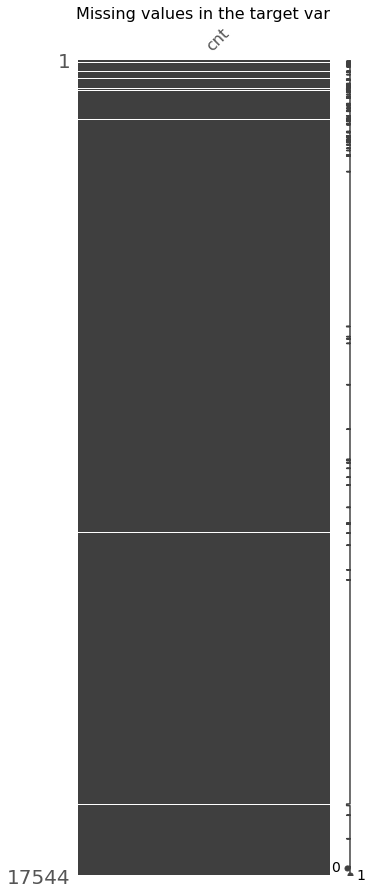

In [13]:
msno.matrix(df[['cnt']], figsize=(5, 15))
plt.title('Missing values in the target var', fontsize=16)
plt.show()

We can see that there are quite a lot of missing hourly observations, especially at the beginning. Let's try to impute it

In [14]:
df['interpolated'] = df.cnt.isnull()
df['interpolated'].sum()

165

I found it looks alright this way, at least we will not be overly optimistic =)) :

In [15]:
df['cnt'] = df.cnt.interpolate(method='akima', order=1)
df['cnt'] = np.where(df.cnt<0, 0, df.cnt)

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals per hour')

Text(0.5, 1.0, 'Bike rentals imputed')

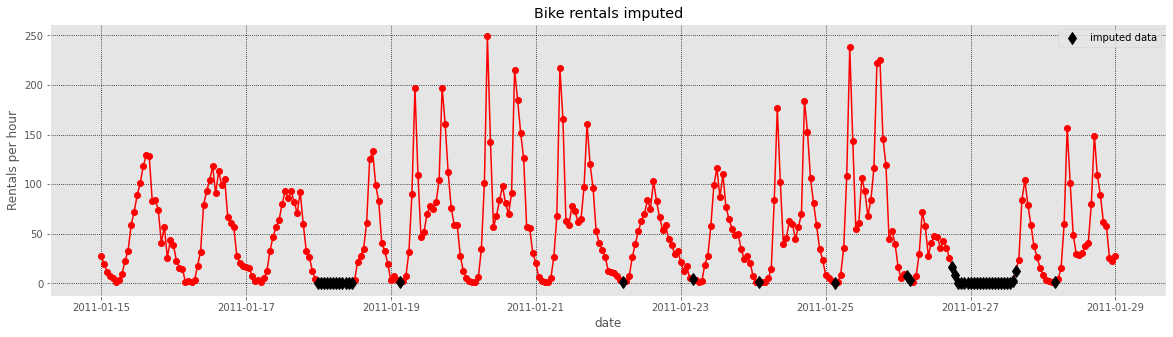

In [16]:
df_imp = pd.Series(df[df.interpolated]['cnt'], 
                         index=df[df.interpolated].index)

start_date = datetime(2011,1,15)
end_date = datetime(2011,1,29)

df_lim = df[start_date:end_date]['cnt']
df_imp_lim = df_imp[start_date:end_date]

plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_lim, '-ro', markersize=6)
plt.plot(df_imp_lim, 'kd', markersize=9, label="imputed data")

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals per hour")
plt.legend()
plt.title("Bike rentals imputed")

plt.show()

## Uniqness constrains

Let's check for duplicate rows:

In [17]:
df.duplicated().sum()

46

We have this number because of the imputation before. I will leave it as is

## Useless data and constans

Let's check for useless fields:

In [18]:
(df.nunique()/len(df)).sort_values(ascending=False)

cnt             0.056259
dteday          0.041667
hum             0.005073
atemp           0.003705
temp            0.002850
windspeed       0.001710
hr              0.001368
mnth            0.000684
weekday         0.000399
season          0.000228
weathersit      0.000228
yr              0.000114
holiday         0.000114
workingday      0.000114
interpolated    0.000114
dtype: float64

We have no unique fields, let's check for constants - fields with zero variance:

In [19]:
df.var().sort_values(ascending=True)[0:5]

interpolated    0.009317
windspeed       0.014967
holiday         0.027944
atemp           0.029532
temp            0.037078
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans

## Data range constrains

Let's see the overall statistics:

In [20]:
df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17544.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,187.835290
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.324806
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,38.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,140.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,279.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


Dataset looks too good to be true =)))

## Profile report

In [21]:
profile = ydata_profiling.ProfileReport(df)
profile.to_file('profile.html')
display(profile)

Output hidden; open in https://colab.research.google.com to view.

Everything looks fine, just vars `hum` and `windspeed` probably will have better shapes after transformation.

## Outliers

As we deal with time series, we have to handle the outliers carefully, because many algorithms depends on smoothing to extract cyclic behaviour. 

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:xlabel='date'>

Text(156.25, 0.5, 'Percent change')

Text(0.5, 1.0, 'Hourly Percent change in 24 hours window')

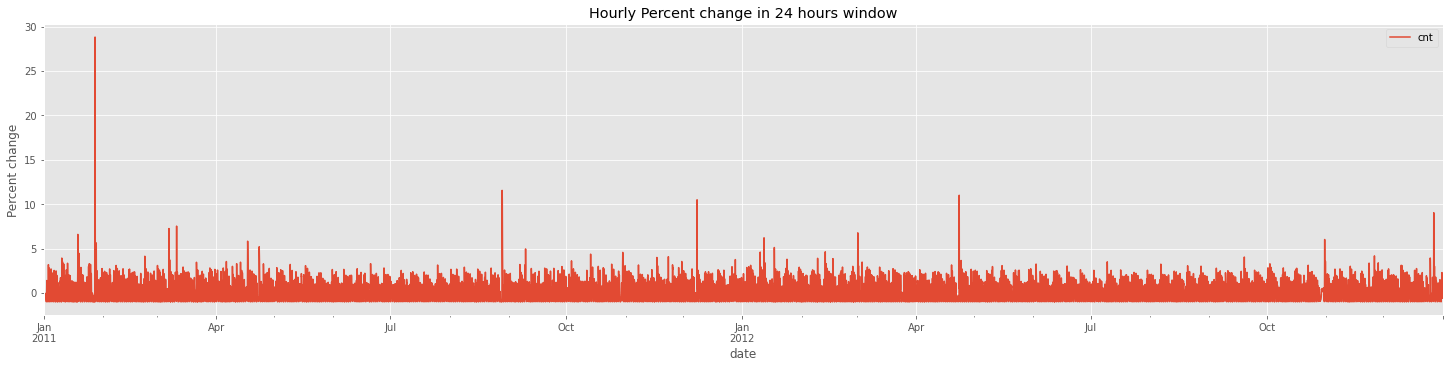

In [22]:
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
plt.subplots(1, 1, figsize=(20, 5))
cnt_perc = df.cnt.rolling(24).apply(percent_change)
cnt_perc.plot()
plt.tight_layout()
plt.ylabel("Percent change")
plt.legend()
plt.title("Hourly Percent change in 24 hours window")
plt.show()

We can see here some big spikes which would be nice to remove

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals per hour')

Text(0.5, 1.0, 'Bike rentals with outliers')

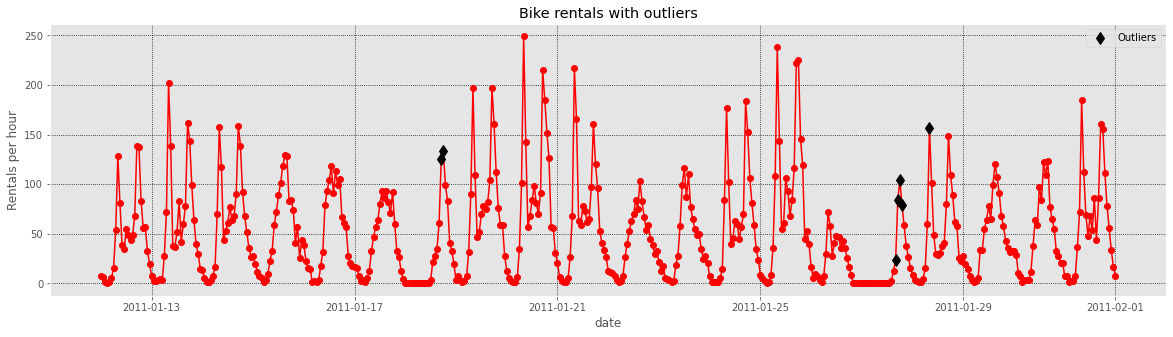

In [23]:
absolute_differences_from_mean = np.abs(cnt_perc - np.mean(cnt_perc))
    
# Calculate a mask for the differences that are > 5 standard deviations from zero
df['outlier'] = absolute_differences_from_mean > (np.std(cnt_perc) * 5)

df_out = pd.Series(df[df.outlier]['cnt'], 
                         index=df[df.outlier].index)

start_date = datetime(2011,1,12)
end_date = datetime(2011,2,1)

df_lim = df[start_date:end_date]['cnt']
df_out_lim = df_out[start_date:end_date]

plt.subplots(1, 1, figsize=(20, 5))

plt.plot(df_lim, '-ro', markersize=6)
plt.plot(df_out_lim, 'kd', markersize=9, label="Outliers")

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals per hour")
plt.legend()
plt.title("Bike rentals with outliers")

plt.show()

In [24]:
df.outlier.sum()

27

Looking at this outliers I have no idea what to do with them. I can try to replace them with smoother version:

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals per hour')

Text(0.5, 1.0, 'Outliers vs smoothed')

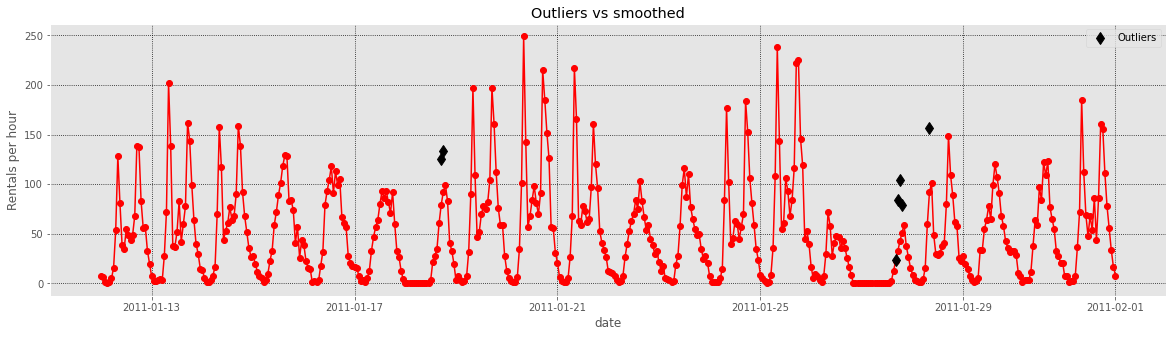

In [25]:
df['cnt'] = np.where(df.outlier, np.nan, df.cnt)

df['cnt'] = df.cnt.interpolate(method='akima', order=1)
df['cnt'] = np.where(df.cnt<0, 0, df.cnt)

plt.subplots(1, 1, figsize=(20, 5))

df_lim = df[start_date:end_date]['cnt']
df_out_lim = df_out[start_date:end_date]

plt.plot(df_lim, '-ro', markersize=6)
plt.plot(df_out_lim, 'kd', markersize=9, label="Outliers")

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals per hour")
plt.legend()
plt.title("Outliers vs smoothed")

plt.show()

Honestly speaking I don't have enough expirience to tell if this will work better, but I will try regression with and without outliers imputing

## Visualising the data

### MA week

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals')

Text(0.5, 1.0, 'Bike rentals weekly moving avg')

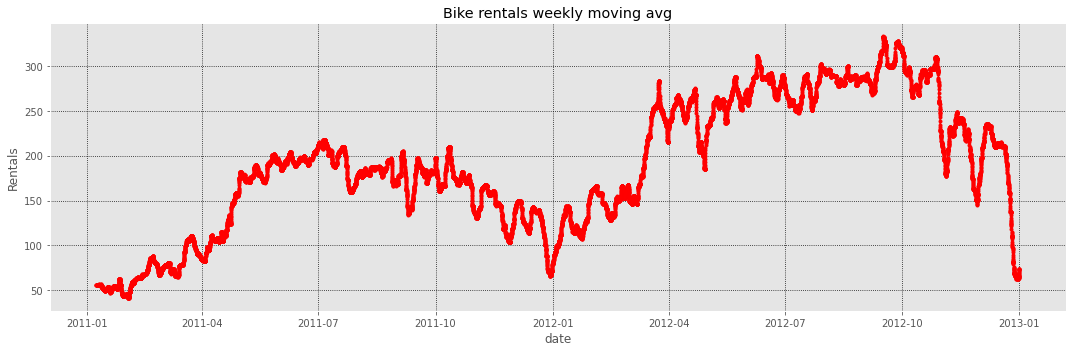

In [26]:
data = df['cnt']

data = data.rolling(24 * 7).mean()
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(data, '-ro', markersize=3)

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals")
plt.title("Bike rentals weekly moving avg")
plt.tight_layout()
plt.show()

We can clearly see the trend here and yearly seasonality, but to see daily and hourly seasonality clear we need a differend scale

### MA day

(<Figure size 1080x288 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals')

Text(0.5, 1.0, 'Bike rentals daily moving avg')

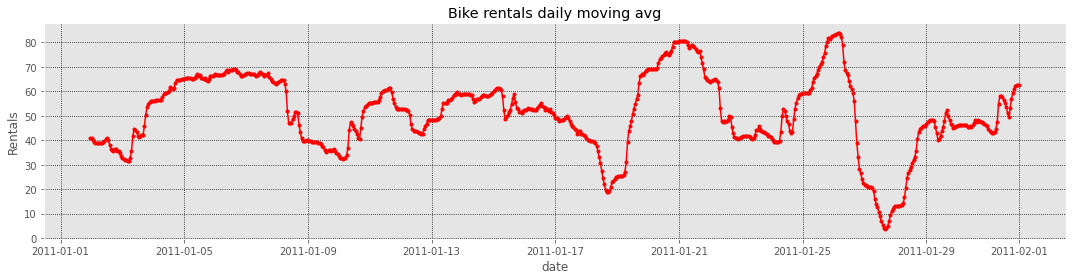

In [27]:
start_date = datetime(2011,1,1)
end_date = datetime(2011,2,1)
df_lim = df[start_date:end_date]

data = df_lim['cnt']
data = data.rolling(24).mean()
plt.subplots(1, 1, figsize=(15, 4))

plt.plot(data, '-ro', markersize=3)

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals")
plt.title("Bike rentals daily moving avg")
plt.tight_layout()
plt.show()

Here we can see some daily/weekly seasonality

### hourly

(<Figure size 1080x288 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'date')

Text(0, 0.5, 'Rentals')

Text(0.5, 1.0, 'Bike rentals hourly')

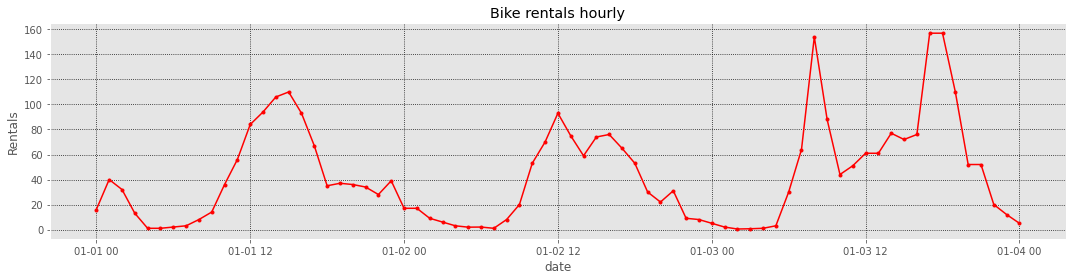

In [28]:
start_date = datetime(2011,1,1)
end_date = datetime(2011,1,4)
df_lim = df[start_date:end_date]

data = df_lim['cnt']
plt.subplots(1, 1, figsize=(15, 4))

plt.plot(data, '-ro', markersize=3)

plt.grid(linestyle=':', color='k')
plt.xlabel("date")
plt.ylabel("Rentals")
plt.title("Bike rentals hourly")
plt.tight_layout()
plt.show()

Here we can see hourly seasonality

So we clearly can see three components - hourly (fluctuations during the day), daily (during the week), and yearly component. 

### yearly seasonal plot

In [29]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    plt.tight_layout()
    piv.plot(figsize=(12,5))    

<Figure size 720x504 with 0 Axes>

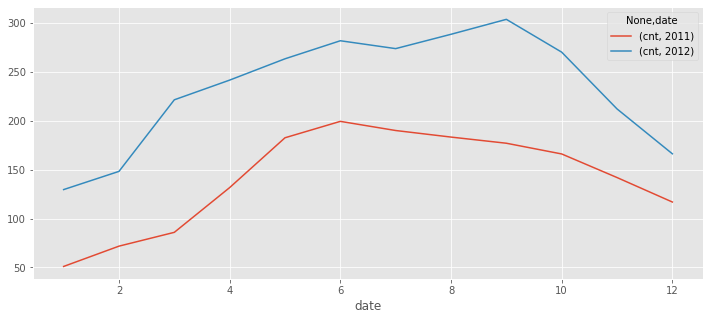

In [30]:
seasonal_plot(df, season='year', index='month', column='cnt')

We can see that the pattern the same - rentals increase in summer, but the second year was a general increase alltogeter

## Decomposition

Because we have multiple seasonality we need a algorithm which support it. 

The reason for the time series analysis is predicting feature, but using result of decomposition as a feature for regression is a huge data leakage (because we don't know the feature, maximum that we know is dates direved features and probably the weather from forecast). 

Because I won't use the decomposition results as a features for regression I can use a full timespan:

In [32]:
end_date = df.index[-1] # - np.timedelta64(1, 'M') - np.timedelta64(1, 'D')

y = df[['cnt']][:end_date]

In [33]:
%%time
stl_kwargs = {
    "seasonal_deg": 0, 
} 
model = MSTL(y, periods=(24, 24 * 7, 24 * 7 * 52), stl_kwargs=stl_kwargs)
res = model.fit()

CPU times: user 5min 25s, sys: 1.76 s, total: 5min 27s
Wall time: 5min 38s


<Figure size 1440x720 with 0 Axes>

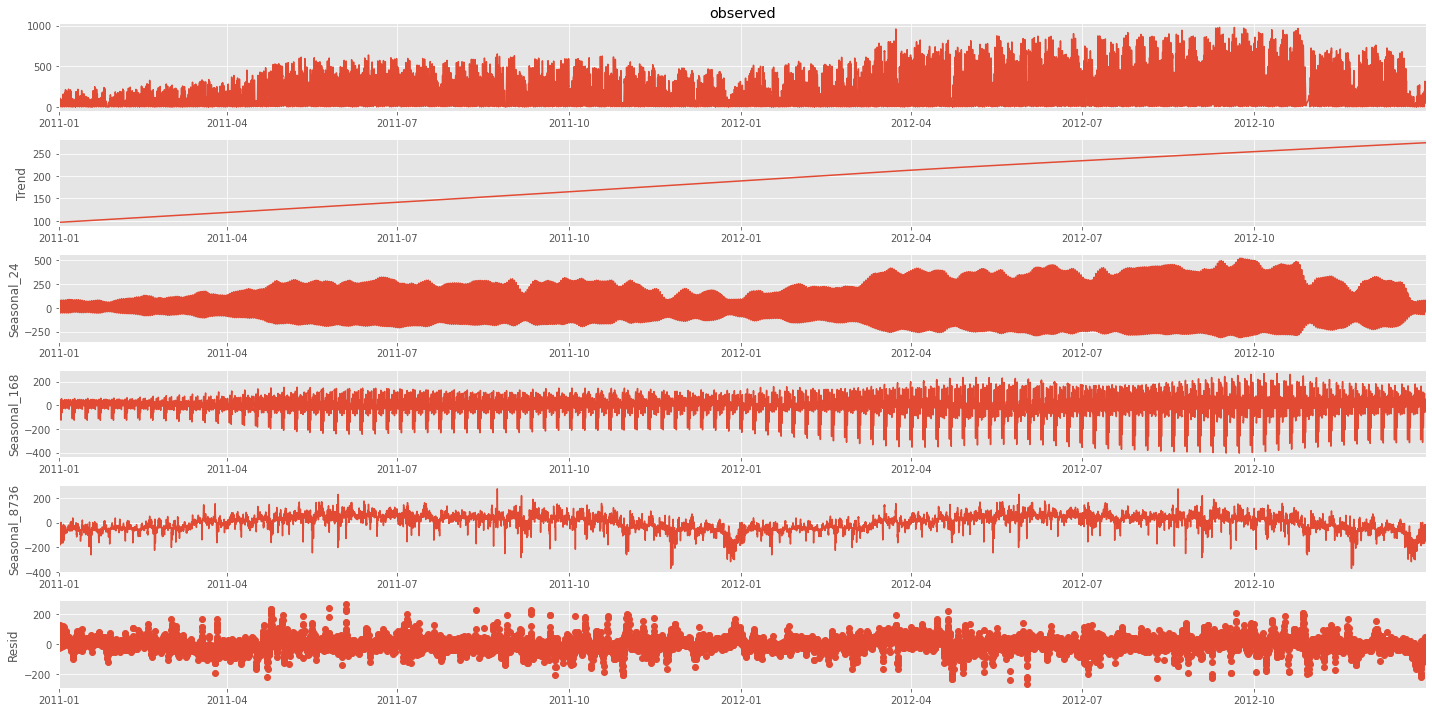

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
plt.tight_layout()
res.plot();

It looks alright - trend is linear and we have a yearly component. Residuals look not like a white noise, let's check the it 

### Residual analysis

#### Autocorrelation

<Figure size 1440x288 with 0 Axes>

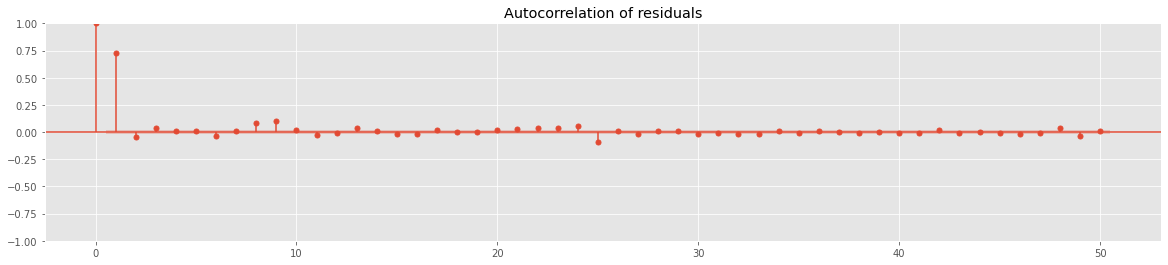

In [ ]:
lags = 50
plt.rcParams["figure.figsize"] = (20,4)
plt.tight_layout()
plot_pacf(res.resid.dropna(), lags=lags, method="ywm",
         title='Autocorrelation of residuals');


The error band is so narrow that I didn't notice it from the beginning =( So there is strong autocorrelation present, which indicate that MSTL with daily, weekly and yearly seasonal components does not catch all the variance in the data. Ideally it should look like a white noice but this is not the case. 

### Feature extraction

This is a huge data leakage if we use it for a regression!!! 

In [ ]:
df['trend'] = res.trend
df['seasonal_24'] = res.seasonal['seasonal_24']
df['seasonal_168'] = res.seasonal['seasonal_168']
df['seasonal_8736'] = res.seasonal['seasonal_8736']

## Sationarity test of the first difference

We can see from the analysis above that we have a trend and seasonality thus our dataset is not stationary in a strict form, let's check the stationarity of the first difference

In [ ]:
first_diff = df['cnt'].diff().dropna()

### Augmented Dickey–Fuller

In [ ]:
alpha = 0.05
print(f"alpha = {alpha}\n")

# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(first_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
    print("The process is stationary.\n")
else:
    print("The process is non-stationary.\n")  

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -29.709136873717473
p-value: 0.0
The process is stationary.



### KPSS test

In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(first_diff, regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
else:
    print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.012801366690961132
p-value = 0.1
The process is stationary.



We have a concensus that the first difference is stationary

## Correlation analysis

To select parameters for ARIMAX model we need to select proper amount of lags, which can be done from the ACF and PACF plots

<Figure size 1440x288 with 0 Axes>

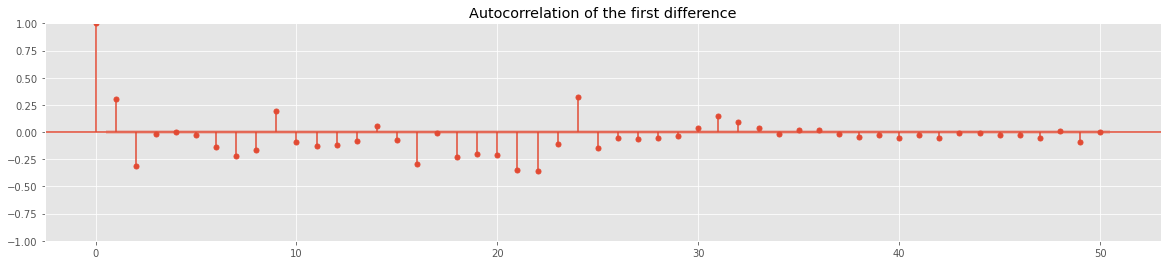

In [ ]:
lags = 50
plt.rcParams["figure.figsize"] = (20,4)
plt.tight_layout()
plot_pacf(first_diff.dropna(), lags=lags, method="ywm",
         title='Autocorrelation of the first difference');

<Figure size 1440x288 with 0 Axes>

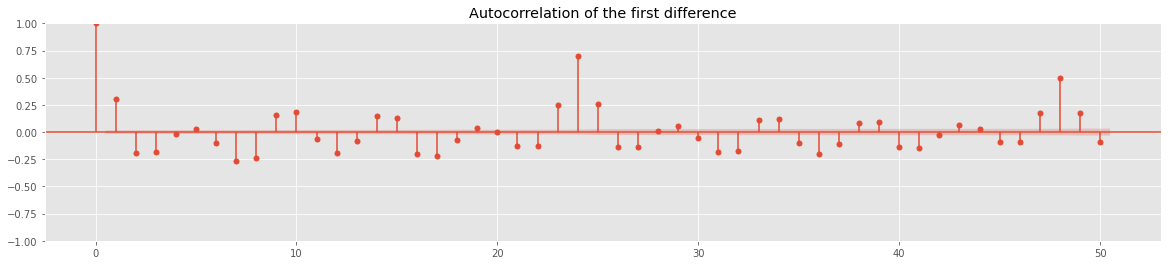

In [ ]:
lags = 50
plt.rcParams["figure.figsize"] = (20,4)
plt.tight_layout()
plot_acf(first_diff.dropna(), lags=lags, 
         title='Autocorrelation of the first difference');

## Target variable

Many algorithms (especially linear) assume that we deal with normally distributed data which is not true IRL. Let's look at the distribution of the target variables:

### cnt

count of total rental bikes including both casual and registered

Text(0.5, 1.0, 'Distribution of the target variable - cnt')

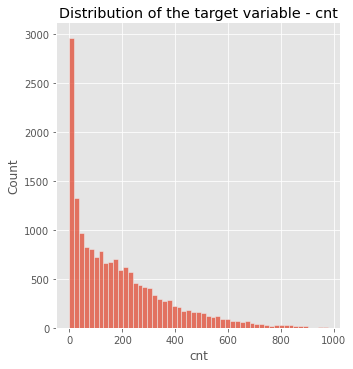

In [ ]:
sns.displot(data=df, x='cnt')
plt.title('Distribution of the target variable - cnt')
plt.show()

We can see that out target variable doesn't have normal distribution. Let's see how the log transformation will look like

Text(0.5, 1.0, 'Distribution of the target variable - cnt after box-cox transf.')

Text(0.5, 6.79999999999999, 'cnt')

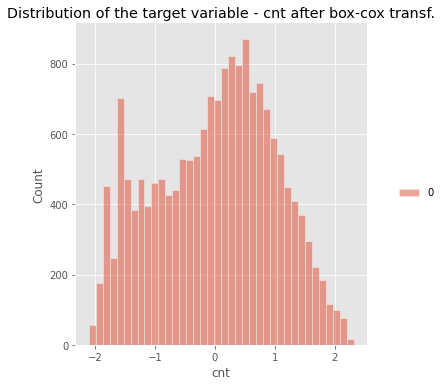

In [ ]:
sns.displot(PowerTransformer().fit_transform(df.cnt.values.reshape(-1,1)))
plt.title('Distribution of the target variable - cnt after box-cox transf.')
plt.xlabel('cnt')
plt.show()

After transformation variable looks much better.

## Independent variables

### Endogenous

Fist of all let's make a new variable - day of the month

In [41]:
df['day'] = df.dteday.dt.day

We have following endogenous features right now:

In [37]:
end_base_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'day']
end_extra_cols = ['trend', 'seasonal_24', 'seasonal_168']

Imputing missing values:

In [ ]:
df['season'] = np.where(df['season'].isnull(), df.index.month // 3 + 1, df['season'])
df['yr'] = np.where(df['yr'].isnull(), df.index.year, df['yr'])
df['holiday'] = np.where(df['holiday'].isnull(), 0, df['holiday'])
df['weekday'] = np.where(df['weekday'].isnull(), df.index.weekday, df['weekday'])
df['workingday'] = np.where(df['workingday'].isnull(), np.logical_not(df.index.weekday), df['workingday'])
df['day'] = np.where(df['day'].isnull(), df.index.day, df['day'])
df['mnth'] = np.where(df['mnth'].isnull(), df.index.month, df['mnth'])
df['hr'] = np.where(df['hr'].isnull(), df.index.hour, df['hr'])

#### Correlations

Let's look at the spearman's correlations between variables. 

<AxesSubplot:>

Text(0.5, 1.0, 'Spearmans corr')

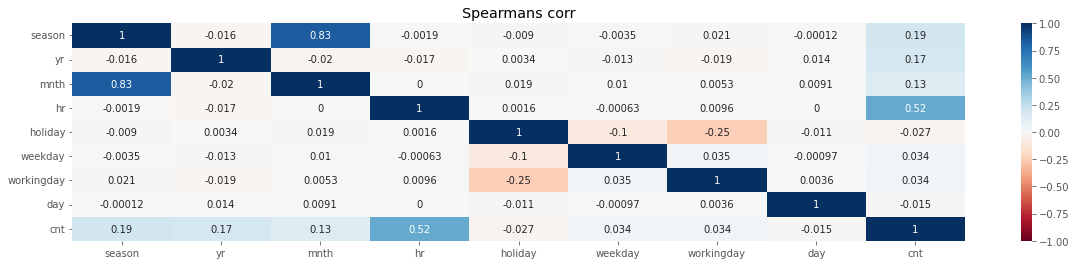

In [ ]:
plot_cols = end_base_cols.copy() # + end_extra_cols
plot_cols.append('cnt')
corr_table = df[plot_cols].corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see here that many of our extrected features have a high correlation with the target

### Exogenous 

In [38]:
exo_cols = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']

#### Correlations

<AxesSubplot:>

Text(0.5, 1.0, 'Spearmans corr')

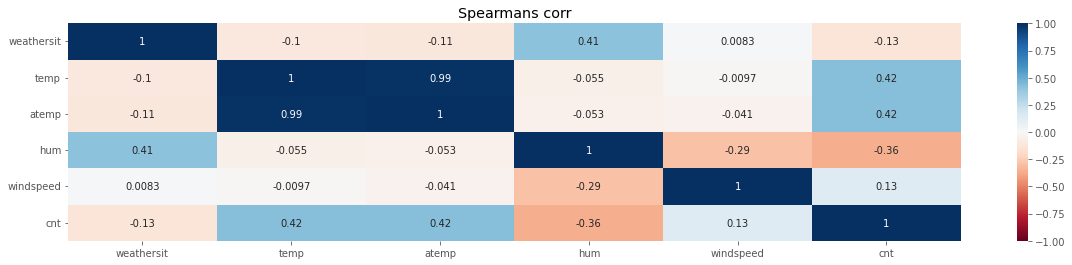

In [ ]:
plot_cols = exo_cols.copy()
plot_cols.append('cnt')
corr_table = df[plot_cols].corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see that temperature and humidity are important features

# Modelling 1 - regression

As we deal with time series we have to use time series splitting. I'm not using here any transformations

## Splitting

In [42]:
y = df['cnt']
X = df[end_base_cols]

start_date = df.index[0]
end_date = df.index[-1] - np.timedelta64(1, 'M') - np.timedelta64(1, 'D')

print(f'Train set start date: {start_date}')
print(f'Train set end date: {end_date}')

train_start_date = end_date + np.timedelta64(1, 'D')

print(f'Test set start date: {train_start_date}')
print(f'Train set end date: {df.index[-1]}')

X_train = X[:end_date]
y_train = y[:end_date]

X_test = X[train_start_date:]
y_test = y[train_start_date:]

X_train.columns

Train set start date: 2011-01-01 00:00:00
Train set end date: 2012-11-30 12:30:54
Test set start date: 2012-12-01 12:30:54
Train set end date: 2012-12-31 23:00:00


Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'day'],
      dtype='object')

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=24,
    test_size=30*24,
)

## Model evaluation function

For my model evaluation I've chosen two the most popular metrics:
* MAE because it was said so in HW instructions =))
* r2 is explained variance and it's easy to compare

In [ ]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):
  
  scorers = {
              'mae': make_scorer(mean_absolute_error, greater_is_better=True),
              'r2': make_scorer(r2_score, greater_is_better=True),
            }

  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring=scorers['mae'], return_train_score=True, error_score="raise")

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  train_score = results['train_score']
  val_score = results['test_score']

  print(f'\nTrain: {train_score.mean():.3f}, Std: {train_score.std():.3f}')
  print(f'Validation: {val_score.mean():.3f}, Std: {val_score.std():.3f}')
  print(f'Test: {mean_absolute_error(y_test, y_pred):.3f}')

  plt.plot(X_test.index, y_test, '-b', label='Test') #label=f"prediction, MAE = {mae_naive:0.3f}")
  plt.plot(X_test.index, y_pred, '--m', label='Predicted') #, label=f"predicted trend")
  plt.grid(linestyle=':')
  plt.legend()
  plt.title("Prediction vs test")
  plt.show()

  return pipeline

## Baseline model

Let's make a baseline model. There is a requirment to use LinearRegression, but results were so sad, so I decided to take the more advanced regressor


Train: 19.377, Std: 0.610
Validation: 56.036, Std: 7.081
Test: 47.671


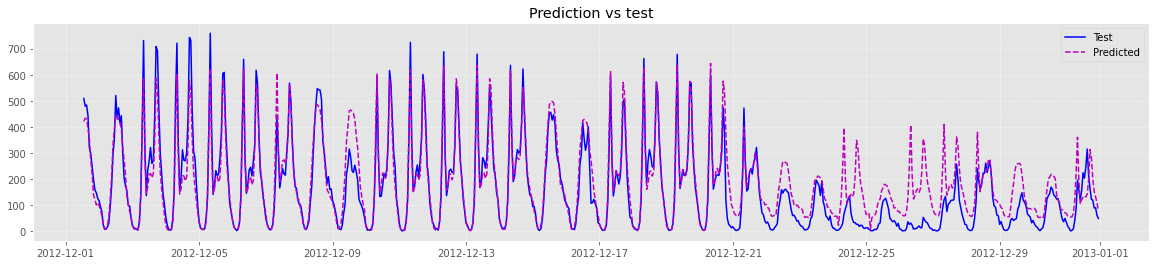

In [ ]:
cat = CatBoostRegressor( 
        verbose=False,
        iterations=1000,
        loss_function='MAE',
        random_seed=42,
        depth=10, 
        min_data_in_leaf=2
    )

ppl_base = evaluate_model(cat, X_train, y_train, X_test, y_test, ts_cv)

Looks alright for a baseline model. Let's add outher features

## Regression full features

I'm not using the decomposition results because it is a huge data leakage!

In [ ]:
all_features = end_base_cols + exo_cols # + end_extra_cols

y = df['cnt']
X = df[all_features]

X_train = X[:end_date]
y_train = y[:end_date]

X_test = X[train_start_date:]
y_test = y[train_start_date:]

print(f'All features: {all_features}')

All features: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'day', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']



Train: 13.663, Std: 0.541
Validation: 41.853, Std: 3.074
Test: 36.428


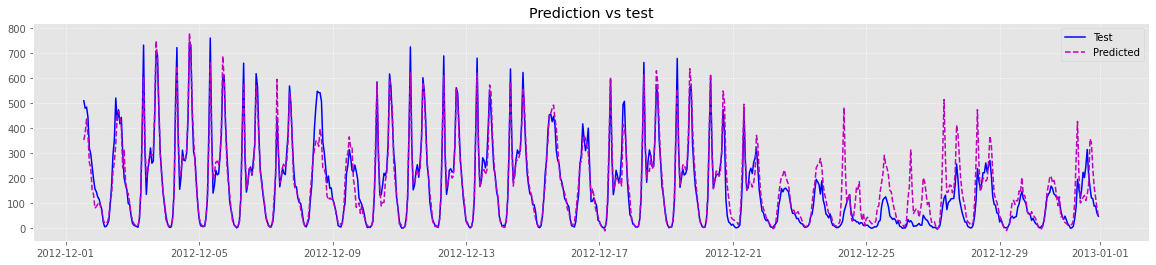

In [ ]:
cat = CatBoostRegressor( 
        verbose=False,
        iterations=1000,
        loss_function='MAE',
        random_seed=42,
        depth=10, 
        min_data_in_leaf=2
    )

ppl_base = evaluate_model(cat, X_train, y_train, X_test, y_test, ts_cv)

That looks a bit better

## Feature importances

<AxesSubplot:>

Text(0.5, 1.0, 'Feature importances')

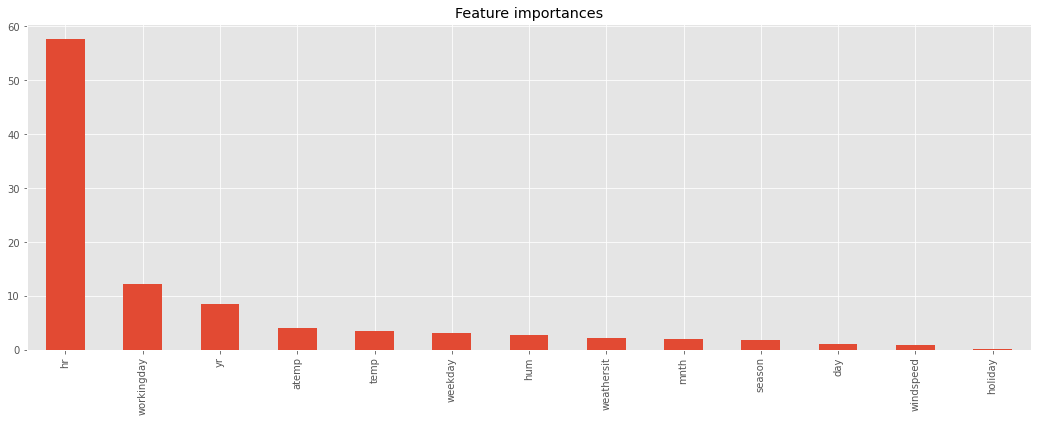

In [ ]:
feature_importance = pd.Series(index = X_train.columns, data = cat.get_feature_importance())

feature_importance.sort_values(ascending=False).plot(kind = 'bar', figsize = (18,6))
plt.title('Feature importances')

We can see that two the most important feature is `hr`

## Residual analysis

Let's look at the plot

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

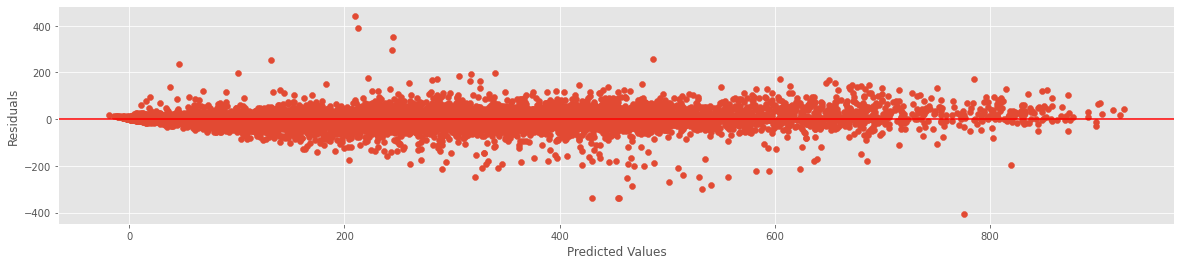

In [ ]:
y_pred = cat.predict(X_train)
residuals = y_train.values.reshape(-1, 1) - y_pred.reshape(-1, 1)
plt.scatter(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.show()

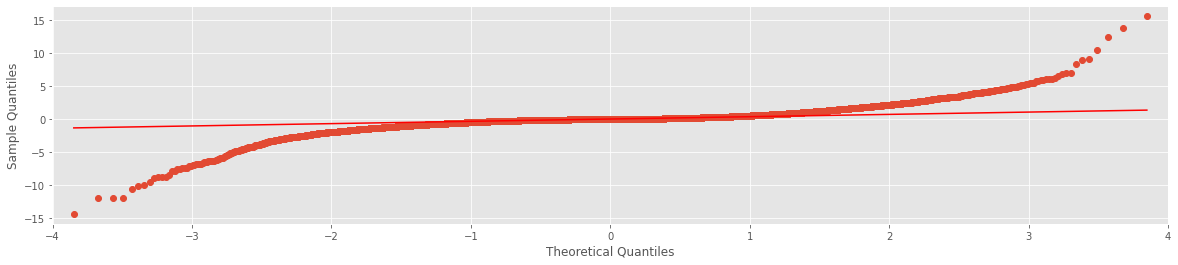

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(np.ravel(residuals), line='q', fit=True);

Distribution is not normal, but looks alrihgt

(<Figure size 1728x576 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

<AxesSubplot:>

Text(0.5, 1.0, 'Residuals')

<AxesSubplot:>

<AxesSubplot:xlabel='Density'>

Text(0.5, 1.0, 'Distribution of residuals')

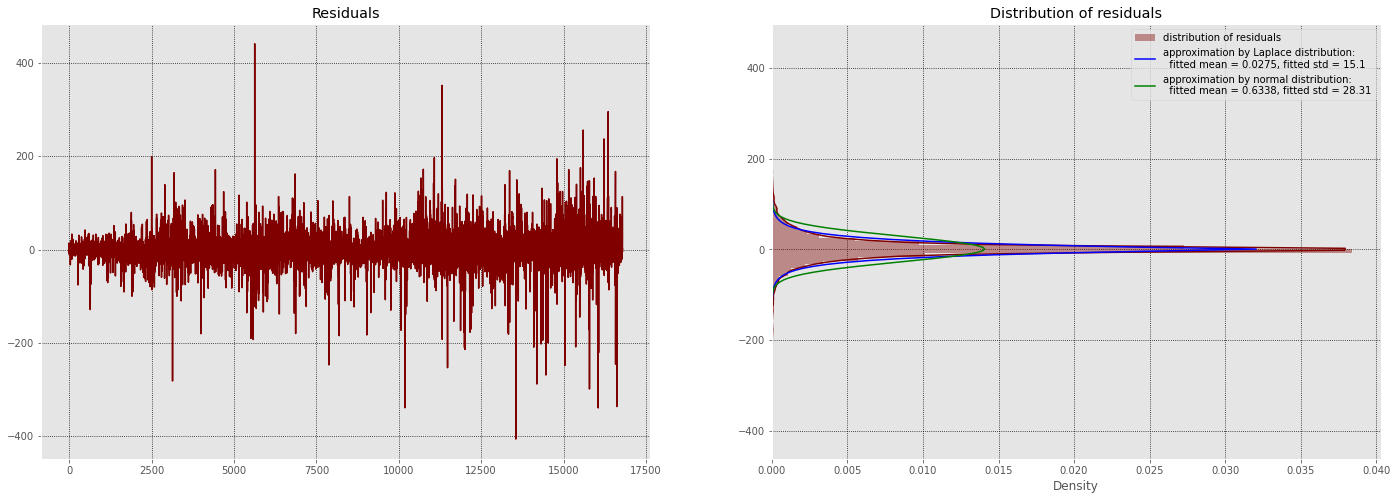

In [ ]:
import scipy.stats as st
resid = residuals
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")

x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid)
loc_norm, scale_norm = st.norm.fit(resid)

y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b', 
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g', 
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()

plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

Laplace distribution is closer to the shape of residuals. 

Let's see autocorrelation plot

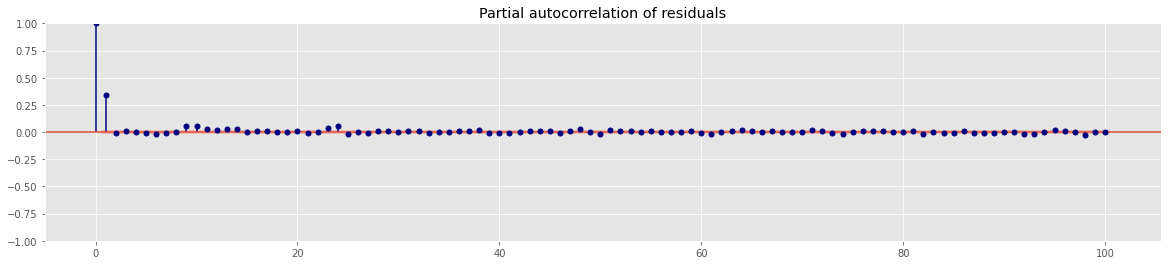

In [ ]:
plot_pacf(resid, 
         lags=100, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of residuals');


We still see some autocorrelation

# Modeling 2 - SARIMAX




I tried ARIMA(24, 1, 24) but it performs exeptionally poorly because there is at least three seasonal components. When I tried to run (24 * 7, 1, 24 * 7) it took to long to calculate (I don't have a good computer or paid account in a cloud).  So I decided to use SARIMAX to include exogenous features. As we saw earlier level 1 difference is stationary, so coefficient for 'I' will be one. To find out coefficients for autoreressive part we need PACF and for moving average we need ACF plots. 

## ACF

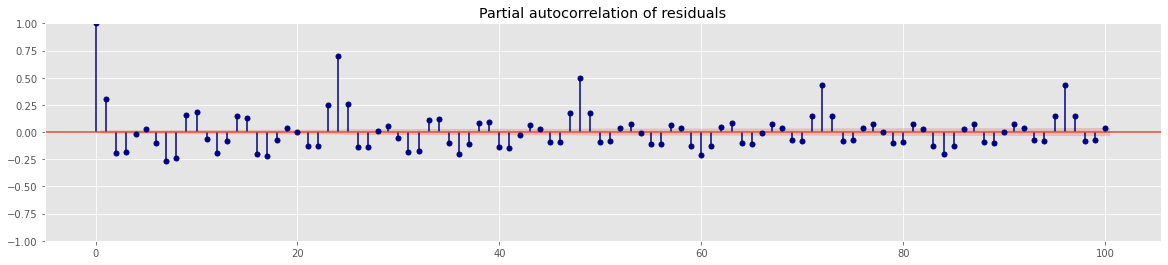

In [ ]:
#first_diff
plot_acf(first_diff, 
         lags=100, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of residuals');


Based on ACF, we should start with a seasonal MA process with 24 lags

## PCF

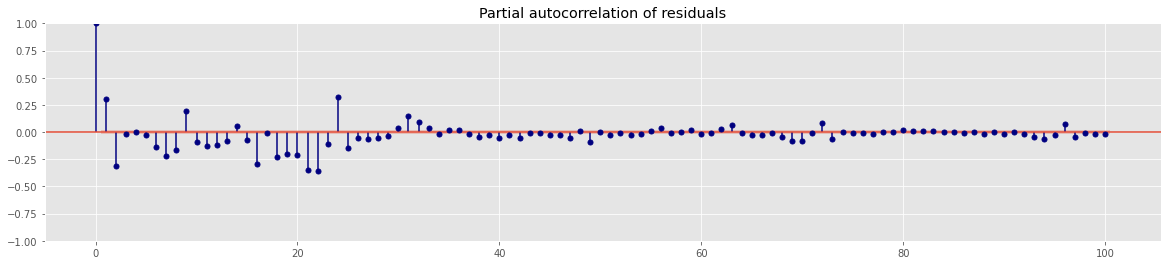

In [ ]:
plot_pacf(first_diff, 
         lags=100, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of residuals');

Based on PACF, we should start with a seasonal AR process with 24 lags

## Splitting

In [43]:
imp = SimpleImputer()

y = df['cnt']
X = df[exo_cols]

X_train = X[:end_date]
y_train = y[:end_date]

X_test = X[train_start_date:]
y_test = y[train_start_date:]

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

## Model

I really would love to run (24, 1, 1)(1, 0, 1, 24*7) to get two seasonal components, but it will take ages to compute.

In [51]:
my_order = (24, 1, 1)
my_seasonal_order = (1, 0, 1, 24*7)
model = SARIMAX(y_train, order=my_order, seasonal_order=my_seasonal_order, 
                exog=X_train)


In [ ]:
%%time
model_fit = model.fit()

In [46]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                16789
Model:             SARIMAX(12, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -91782.201
Date:                             Tue, 14 Mar 2023   AIC                         183606.402
Time:                                     15:20:43   BIC                         183768.699
Sample:                                 01-01-2011   HQIC                        183659.955
                                      - 11-30-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1039      0.066     -1.585      0.113      -0.232       0.025
x2            96.9666     3

We can see that all SARIMA coefficients, except for AR L4, L8, and L11, are significant, and X features are `temp`, `hum`, `windspeed`

In [47]:
#get the predictions and residuals
predictions = model_fit.forecast(len(X_test), exog=X_test)
predictions = pd.Series(predictions, index=X[train_start_date:].index)
residuals = y_test - predictions


<Figure size 1440x288 with 0 Axes>

Text(0.5, 1.0, 'Bike rentals per hour')

Text(0, 0.5, 'Rentals')

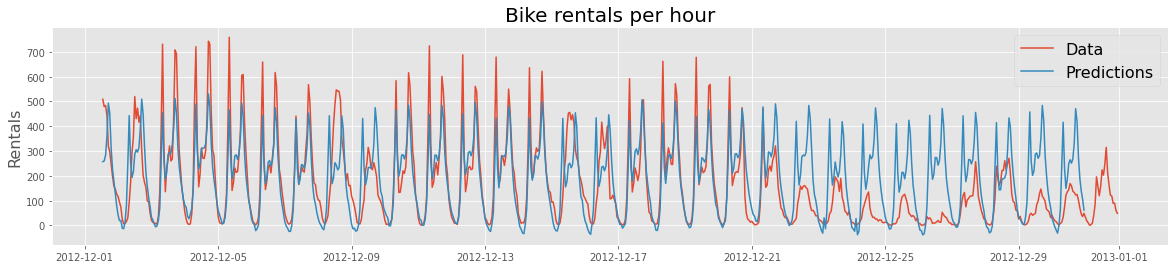

In [48]:
plt.figure(figsize=(20,4))

plt.plot(y_test)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike rentals per hour', fontsize=20)
plt.ylabel('Rentals', fontsize=16)

From the graph above we can see that weakly seasonality not captured correctly. I have no indea how to force forecast extarpolate the last 24 hours, so for now I'm just drop if off

In [49]:
mean_absolute_error(y_test[:len(predictions)-24], predictions[:len(predictions)-24])

85.17846005724495

The result is significantly worse than the CatBoostRegressor

## Residual analysis

Text(0.5, 1.0, 'Residuals from ARIMA Model')

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

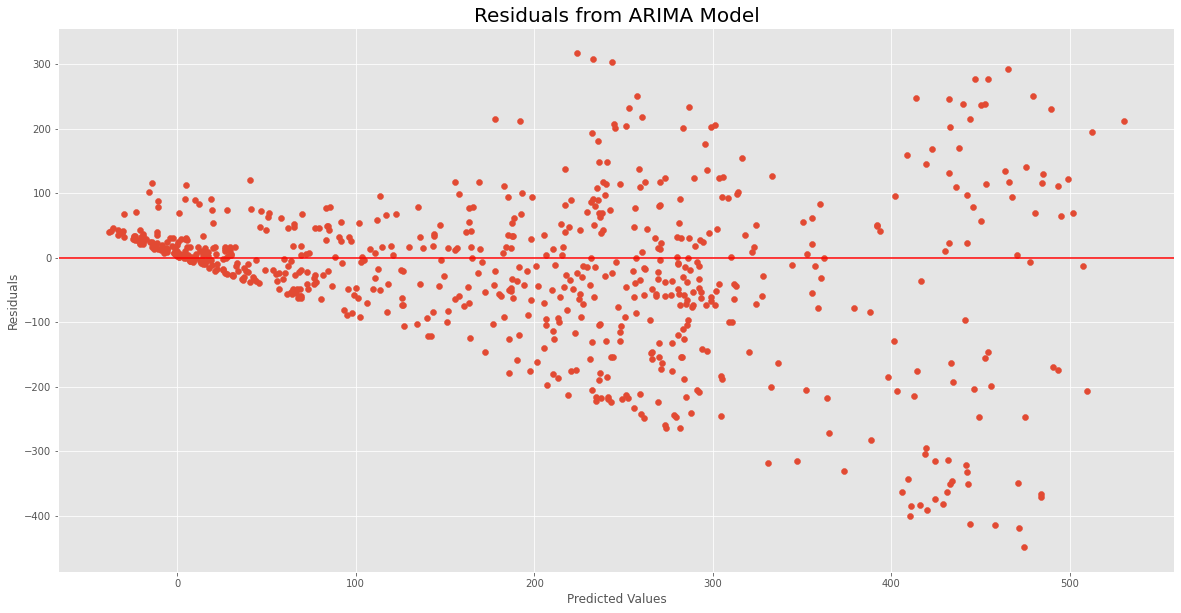

In [50]:
plt.scatter(x=predictions, y=residuals)
plt.axhline(0, color='red')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.show()

Residuals look bad - heteroskedastisity non-linear trend and bias present. There is no point to run any tests - this model is not suitable for the data. 

# Modeling 3 - TBATS

**Not compatible with the new statsmodel, I hope guys will fix it soon.**

I want to try out models which natively can deal with multiple seasonality. 

The names are acronyms for key features of the models: Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components.

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [ ]:
!pip install tbats

In [ ]:
from tbats import TBATS, BATS
model = TBATS(seasonal_periods=(24, 24 * 7, 24 * 7 *52))
model_fit = estimator.fit(y_train)# Forecast 365 days ahead
y_forecast = model_fit.forecast(steps=365)

ImportError: ignored

# Modeling 4 - PROPHET

## Splitting

In [183]:
y = df[['cnt']]
y.columns=['y']
y['ds'] = y.index
y[exo_cols] = df[exo_cols]
y[end_base_cols] = df[end_base_cols]
y.info()

end_date = df.index[-1] - np.timedelta64(1, 'M') - np.timedelta64(1, 'D')
train_start_date = end_date + np.timedelta64(1, 'D')

y_train = y[:end_date]
y_test = y[train_start_date:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   y           17544 non-null  float64       
 1   ds          17544 non-null  datetime64[ns]
 2   weathersit  17379 non-null  float64       
 3   temp        17379 non-null  float64       
 4   atemp       17379 non-null  float64       
 5   hum         17379 non-null  float64       
 6   windspeed   17379 non-null  float64       
 7   season      17379 non-null  float64       
 8   yr          17379 non-null  float64       
 9   mnth        17379 non-null  float64       
 10  hr          17379 non-null  float64       
 11  holiday     17379 non-null  float64       
 12  weekday     17379 non-null  float64       
 13  workingday  17379 non-null  float64       
 14  day         17379 non-null  float64       
dtypes: datetime64[ns](1), float

## Model

In [184]:
m = Prophet()
m.fit(y_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6glfr8q2/7dqnsoz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6glfr8q2/jdie7bzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45940', 'data', 'file=/tmp/tmp6glfr8q2/7dqnsoz5.json', 'init=/tmp/tmp6glfr8q2/jdie7bzo.json', 'output', 'file=/tmp/tmp6glfr8q2/prophet_modelx_4ou82q/prophet_model-20230314141252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [185]:
future = pd.DataFrame({
    'ds':y_test.index})
future[exo_cols] = y_test[exo_cols]
future[end_base_cols] = y_test[end_base_cols]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
726,2012-12-31 19:00:00,383.113306,235.794484,528.859155
727,2012-12-31 20:00:00,288.797864,158.776641,427.965500
728,2012-12-31 21:00:00,189.940647,48.222778,337.954978
729,2012-12-31 22:00:00,126.904482,-9.886500,272.023736
730,2012-12-31 23:00:00,108.546776,-38.199108,244.408843


In [186]:
mean_absolute_error(y_test['y'].values, forecast['yhat'].values)

106.55755935147096

The result is worse than SARIMAX (MAE is 106.6), but it takes seconds to fit which is nice. 

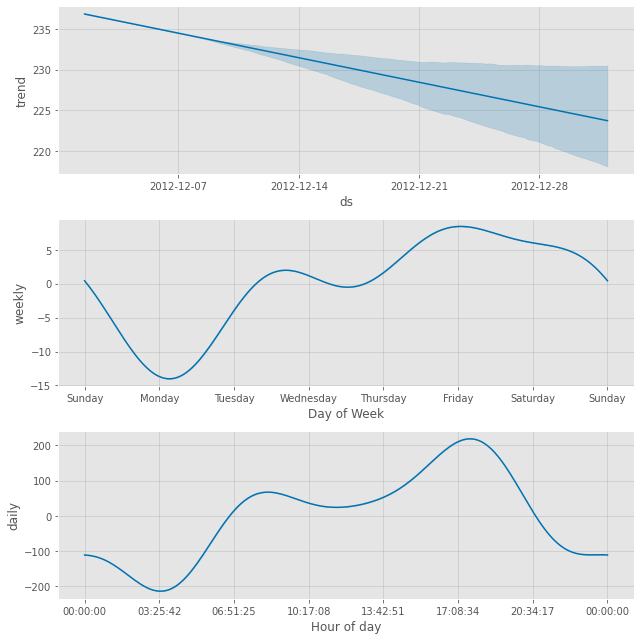

In [187]:
fig2 = m.plot_components(forecast)

daily component looks fine, not sure about weekly, but it did not capture yearly component and trend. Model does not work good from the box. I will try to improve it if I have time left

In [188]:
forecast.set_index('ds', inplace=True)

<Figure size 1440x288 with 0 Axes>

Text(0.5, 1.0, 'Bike rentals per hour')

Text(0, 0.5, 'Rentals')

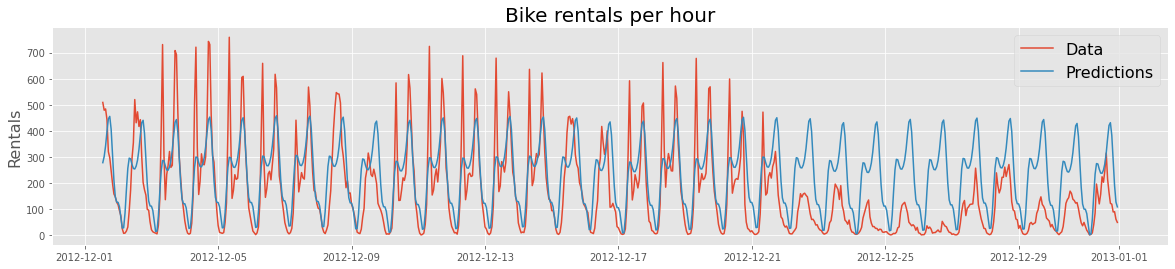

In [189]:
plt.figure(figsize=(20,4))

plt.plot(y_test['y'])
plt.plot(forecast['yhat'])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Bike rentals per hour', fontsize=20)
plt.ylabel('Rentals', fontsize=16)

From the graph above we can see that weakly seasonality not captured correctly. 

## Residual analysis

Text(0.5, 1.0, 'Residuals from PROPHET Model')

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

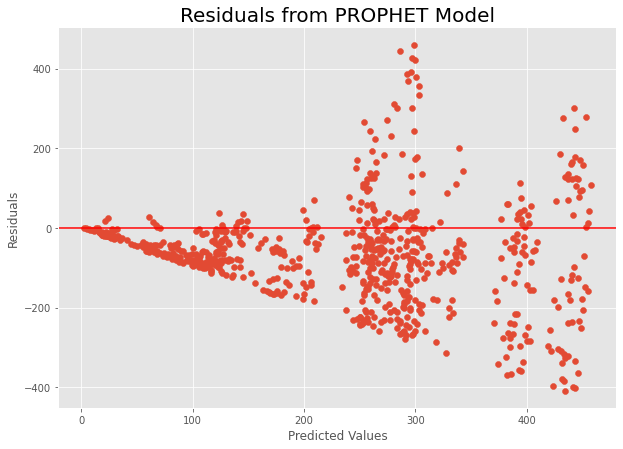

In [190]:
residuals = y_test['y'].values - forecast['yhat'].values
plt.scatter(x=forecast['yhat'].values, y=residuals)
plt.axhline(0, color='red')
plt.title('Residuals from PROPHET Model', fontsize=20)
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.show()

Huge heteroscedasticity, strong bias - model is not appropriate for the data. 

# Conclusion

The best model so far is CatBoostRegressor and surprisingly PROPHET 'from the box' is the worst. SARIMAX is OK, but it takes huge amount of time to fit if take many lags into account (which is needed to capture multiple seasonality for this dataset). 